# Back to the basics: Single Path discovery

In [1]:
%load_ext autoreload
%autoreload 2

import networkx as nx
# import scipy
import matplotlib.pyplot as plt


# import clique_discovery 
# from helpers import *

Find the longest sequences of symbols that appears consequtively in a set of traces.


In [2]:
def graph(G, color="#cccccc", with_weigths=True):
    pos = nx.circular_layout(G)
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.subplot(111)

    nx.draw_networkx (G, pos, width=1, node_color=color, with_labels=True, connectionstyle='arc3, rad=0.03' )
    if with_weigths:
        weights = { (str(u), str(v)): G[u][v]['weight'] for u,v in G.edges() }
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=weights)
    plt.show()

In [62]:
T = [
    list("ABCD345ABCD12"),
#     list("12abc34abc56abc"),
#     list("13")
]
NAIVE=nx.DiGraph()
NAIVE.add_edges_from( [ (a,b) for t in T for a,b in zip( t[:-1], t[1:] )  ] )
# graph( NAIVE, with_weigths=False )


In [63]:
def get_successor_pairs( T_prime ):
    """
    Get near successor pairs
    
    Given the trace $T' = s_1 ... s_L$
    For every $1 <= i <= L$ find the maximal subtrace starting at $i$
    $T_i_j = s_i ... s_j$ such that $s_i \ne s_k$ for all $i < k <= j$
    
    Return the concatenation for all $T_i_j$
    [ (s_i, s_k) ] for all s_i \in T_i_j, s_k \in T_i_j for all i < k <= j

    
    >>> get_successor_pairs(list("ABCD"))
    [('A', 'B'), ('A', 'C'), ('A', 'D'), ('B', 'C'), ('B', 'D'), ('C', 'D')]
    """
    pairs = []
    for i in range(0, len(T_prime)-1):


        partial_subtrace = T_prime[i:]

        s_i = partial_subtrace.pop(0)
        L = len(partial_subtrace)

        # Find first first j such s_i == s_j, or L if not exists
        if s_i in partial_subtrace:
            j = partial_subtrace.index(s_i)
        else:
            j = L

        # This is the subtrace T_i_j, the maximal that not contains s1
        # (Actually, it not contains s_i)
        T_i_j=partial_subtrace[:j]

        # Construct all s_i, s_k , i < k <= j
        for s_k in T_i_j:
            e = (s_i, s_k)
            pairs.append(e)
            
            # Added 2020-01-18: global star / end
#             if ADD_START_END:
#                 pairs.append( ("_START_", s_i) )
#                 pairs.append(( s_k, "_END_") )


    return pairs

In [64]:
def get_successor_pairs_by_freq( traces ):
    """
    Get successor pairs in every T in traces, and combine them by frequency of appearance.
    
    >>> T = [ list("ABC"), list("ABCABC") ]
    >>> get_successor_pairs_by_freq(T)
    {('A', 'B'): 3, ('A', 'C'): 3, ('B', 'C'): 3, ('B', 'A'): 1, ('C', 'A'): 1, ('C', 'B'): 1}
    """
    pairs_by_freq = {}
    L = float(len(traces))

    for trace in traces:
        for pair in get_successor_pairs(trace):
            if pair in pairs_by_freq.keys():
                pairs_by_freq[pair] = pairs_by_freq[pair] + 1.0/L
            else:
                pairs_by_freq[pair] = 1.0/L
            
    return pairs_by_freq

In [65]:
succ_by_f = get_successor_pairs_by_freq(T)
#succ_by_f

In [66]:
# Build an auxiliary succ_by_f graph
def successors_graph( succ_by_f ):
    G = nx.DiGraph()
    for p in succ_by_f.keys():
        G.add_edge(p[0], p[1], weight=succ_by_f[(p[0], p[1])] )
        
    return G

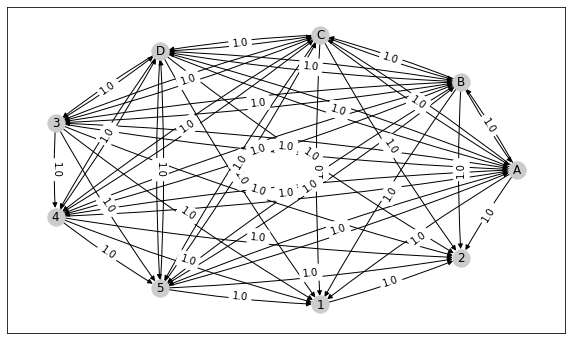

In [67]:
# Build an auxiliary succ_by_f graph
G_succ = successors_graph( succ_by_f )
graph(G_succ)

In [82]:
# Have a loop? Sorry, dude, no loops allowed. Keep the bigger weight.
def remove_loops(H):
    """
    Is loop iff deg(AB) - deg(BA)=1
    AB AB AB AB AB .. AB AB
     BA BA BA BA BA .. BA
    """
    loops = []
    G = H.copy()
    G_loops = nx.DiGraph()
    for u in G.nodes:
        for v in (G.nodes - u):
            # Yes, a loop
            if (u,v) in G.edges and (v,u) in G.edges:
                # Keep the greater weight
                if G.edges[u,v]['weight'] > G.edges[v,u]['weight']:
                    a, b = v, u
                else:
                    a, b = u, v
                Wba, Wab = G.edges[b,a]['weight'], G.edges[a,b]['weight']
                #
                # Truquito.. weights enteros => loop
                #
                if Wba == round(Wba) and  Wab == round(Wab):
                    G_loops.add_edge( b,a, weight = Wba ) 
                    G_loops.add_edge( a,b, weight = Wab ) 

                G.remove_edge(a, b)
#                 G.remove_edge(b, a)

    return G, G_loops

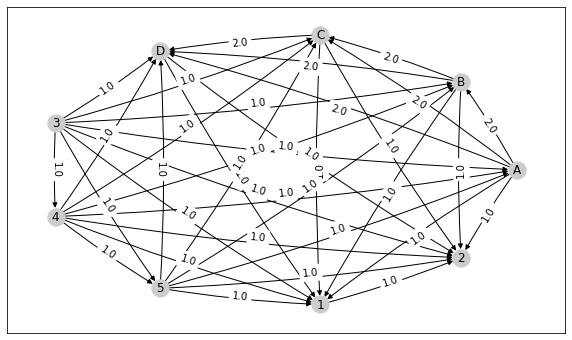

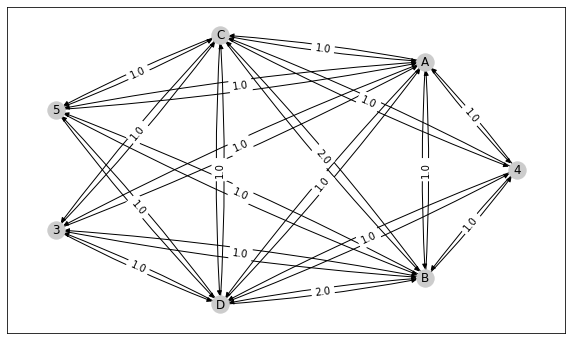

In [83]:
G_dag, G_loops = remove_loops(G_succ)
graph(G_dag)
graph(G_loops)

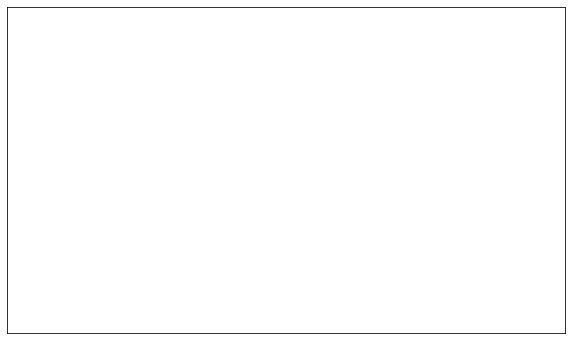

In [84]:
# Show graph for some weight
w = 3

G_dag_w = nx.DiGraph()
for e in G_dag.edges.data():
    if e[2]['weight'] == w:
        G_dag_w.add_edge(e[0], e[1], weight=w)
graph(G_dag_w)

In [85]:
# Search cliques in some weight
def cliques_in_f( G, w ):
    # Build a filtered graph
    G_w = nx.DiGraph()
    for e in G.edges.data():
        if e[2]['weight'] == w:
            G_w.add_edge(e[0], e[1], weight=w)

    return nx.algorithms.clique.find_cliques(G_w.to_undirected())

In [86]:
# Search cliques in some weight
# Using the same graph shown above
list(cliques_in_f(G_dag, 1))

[['4', '5', '1', '3', '2', 'B'],
 ['4', '5', '1', '3', '2', 'A'],
 ['4', '5', '1', '3', '2', 'C'],
 ['4', '5', '1', '3', '2', 'D']]

In [87]:
def get_ordered_cliques_in(G):
    weights = set( [G[u][v]['weight'] for u,v in G.edges()] )
    cliques = { w: list(cliques_in_f(G, w)) for w in weights }

    new_cliques={}
    for f, C in cliques.items():
        new_cliques[f] = []
        for path in C:
            # Order nodes by in degree
            new_cliques[f].append( sorted( path , key=lambda p: G.in_degree(p) ) )
    return new_cliques      

In [88]:
ordered_cliques = get_ordered_cliques_in(G_dag)
ordered_cliques

{1.0: [['3', '4', '5', 'B', '1', '2'],
  ['3', '4', '5', 'A', '1', '2'],
  ['3', '4', '5', 'C', '1', '2'],
  ['3', '4', '5', 'D', '1', '2']],
 2.0: [['A', 'B', 'C', 'D']]}

In [89]:
# Build a graph from the cliques preserving weight 
def cliques_graph(cliques):
    G_cliques = nx.DiGraph()
    for w in cliques:
        for C in cliques[w]:
            for i in range(1, len(C)):
                G_cliques.add_edge( C[i-1], C[i], weight=w )
    return G_cliques

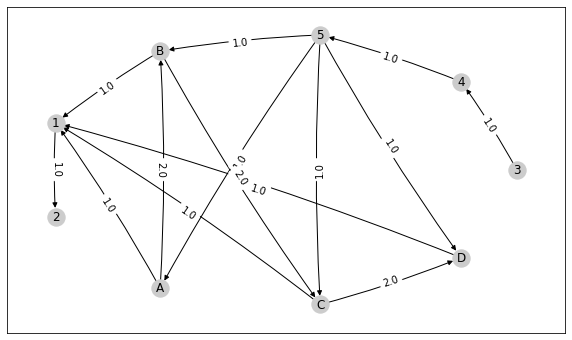

In [90]:
G_cliques = cliques_graph(ordered_cliques)
graph(G_cliques)

In [91]:
def minimally_connected(G):
    G_minimal = G.copy()
    for u, v in G.edges():

        # u has already v, then I will work if I have more than one neighbor
        if len(G[u]) > 1:
            remove_edge = False
            # look if I have a longest u,z,v path
            for z, attr in G[u].items():
                if z != v and z != u:
                    if nx.has_path(G_minimal, z, v):
                        remove_edge = True
            if remove_edge:
                G_minimal.remove_edge( u, v )
    return G_minimal

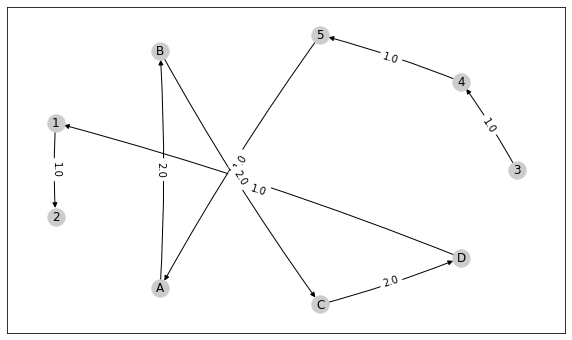

In [95]:
# minimally_connected( cliques_graph( get_ordered_cliques_in(G_dag) ) )
SerialGraph = minimally_connected(G_cliques)
graph(SerialGraph)

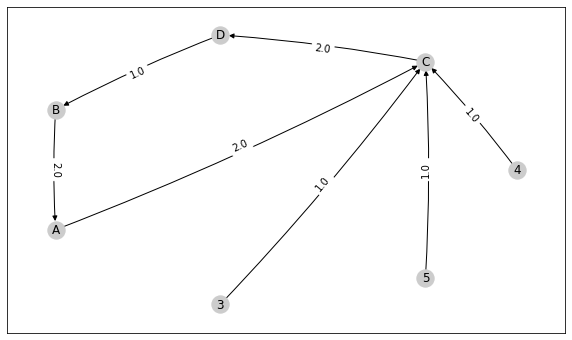

In [93]:
LoopsGraph = minimally_connected( cliques_graph( get_ordered_cliques_in(G_loops) ) )
graph(LoopsGraph)
                                 

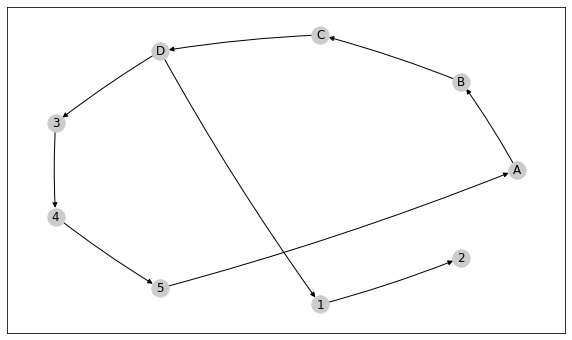

In [94]:
graph( NAIVE, with_weigths=False )